# LPIS data for Slovenia
In this notebook we will look at necessary steps to downoad and process the LPIS data for Slovenija. We will prepare multiple EOTasks that will be later run all in the same workflow.

## Requirements
* patch with bbox and at least one data feature which is used to match dimensions with LPIS mask *(relevant [notebook](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb))*

## Steps
* Loading and saving of patches
* Adding LPIS vector feature from geopedija
* Calculating area ratio feature
* Fixing some known LPIS mistakes
* Defining final clustered groups rematching the labels
* Transforming LPIS vector mask to raster mask
* Visualization of result



In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import numpy as np
import pandas as pd
import sys
from eolearn.core import EOTask, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, EOPatch
from eolearn.geometry import VectorToRaster
import os
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

# This should be included somewhere else
from notebook_temporary.tasks import FixLPIS, CreatePatch, AddGeopediaVectorFeature, AddAreaRatio


# LPIS layer id-s needed to download
GEOPEDIA_LPIS_LAYERS = {'Denmark_LPIS_2018': 2051,
                        'Denmark_LPIS_2017': 2051,
                        'Denmark_LPIS_2016': 2051,
                        'Austria_LPIS_2017': 2034,
                        'Austria_LPIS_2016': 2033,
                        'Slovenia_LPIS_2017': 2038,
                        'Slovenia_LPIS_2016': 2037,
                        'Austria_FELDSTUECKE_2017': 2029,
                        'Austria_FELDSTUECKE_2016': 2027}

### Loading and saving of the patches
Change the `input_path` and `save_path` to where you have your patches saved and where you want to save the result if it is not in the same folder

In [39]:
input_path = f'{os.getcwd()}/patches'
save_path = input_path
year = 2017
country = 'Slovenia'
load = LoadTask(input_path)
if not os.path.isdir(save_path):
    os.makedirs(save_path)
save = SaveTask(save_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Tasks for downloading LPIS

In [40]:
# Adding LPIS vector feature from geopedija
layer_id = GEOPEDIA_LPIS_LAYERS[f'{country}_LPIS_{year}']
name_of_feature = f'LPIS_{year}'
add_lpis = AddGeopediaVectorFeature((FeatureType.VECTOR_TIMELESS, name_of_feature),
                                    layer=layer_id, year_filter=('LETO', year), drop_duplicates=True)

# This task adds a timeless scalar feature that tells how much of the area is the chosen feature. This is used for excluding
# patches with no or small amount of data.
area_ratio = AddAreaRatio((FeatureType.VECTOR_TIMELESS, name_of_feature),
                          (FeatureType.SCALAR_TIMELESS, 'FIELD_AREA_RATIO'))

# Fixes some known mistakes such as non integer indices
fixlpis = FixLPIS(feature=name_of_feature, country=country)

### Defining final clustered groups and renaming the labels
There is about 170 different crop types in Slovenia. A lot of those classes are really similar to eachother so it makes sense to join them. In following excel file there are proposed two groupings. Group 1 consists of 24 classes and Group 2 consists of 13 classes. In this example will be using the Group 2.

In [41]:
class AddGroup(EOTask):
    def __init__(self, dictionary, name_of_feature='LPIS_2017'):
        self.name_of_feature = name_of_feature
        self.dictionary = dictionary

    def execute(self, eopatch):
        gdf = eopatch.vector_timeless[self.name_of_feature]
        gdf['GROUP'] = [self.dictionary[i] for i in gdf.SIFKMRS]
        eopatch.vector_timeless[self.name_of_feature] = gdf
        return eopatch

In [42]:
slo_grouping = pd.read_excel(f'{os.getcwd()}/notebook_temporary/SLO_LPIS_grouping.xlsx')
slo_grouping.rename(index=str, columns={"Group 2": "GROUP_2", "SIFKMRS": "CROP_ID"}, inplace=True)
slo_grouping['CROP_ID'][99] = '1204'
crop_ids = slo_grouping.CROP_ID.values.astype(int)
group_ids = slo_grouping.GROUP_2.values
unique_groups = np.unique(slo_grouping.GROUP_2.values)
groups_to_number = dict(zip(unique_groups, range(len(unique_groups))))
crops_to_number = dict(zip(crop_ids, [groups_to_number[i] + 1 for i in group_ids]))

add_group = AddGroup(crops_to_number, name_of_feature)

C:\Users\bsircelj\.conda\envs\eolearn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Transforming LPIS vector mask to raster mask


In [43]:
rasterize = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, name_of_feature),
                           raster_feature=(FeatureType.MASK_TIMELESS, name_of_feature),
                           values=None,
                           values_column='GROUP',
                           raster_shape=(FeatureType.DATA, 'BANDS'),
                           raster_dtype=np.int16,
                           no_data_value=0
                           )

### Whole workflow
Because the AddGeopediaVectorFeature doesn't save anything if the patch doesn't contain any LPIS data the steps area_ratio fixlpis and rasterize should not be executed in those cases as it would only come to an error. Because of this we define another custom task that either runs the extra tasks or saves a LPIS mask with every point set to 0 which stands for `Not Farmland`.

In [44]:
class WorkflowExclude(EOTask):
    def __init__(self, *extra_tasks, feature='LPIS_2017', feature_type=FeatureType.VECTOR_TIMELESS):
        self.feature = feature
        self.feature_type = feature_type
        self.extra_tasks = extra_tasks

    def execute(self, eopatch):
        if self.feature not in eopatch[self.feature_type]:
            bands = next(iter(eopatch.data))
            fet = np.zeros(bands[0, :, :, 0].shape, dtype=np.int8)
            eopatch.add_feature(FeatureType.MASK_TIMELESS, self.feature, fet[..., np.newaxis])
            return eopatch
        for t in self.extra_tasks:
            eopatch = t(eopatch)
        return eopatch

In [45]:
exclude = WorkflowExclude(area_ratio, fixlpis, add_group, rasterize)

workflow = LinearWorkflow(
    load,
    add_lpis,
    exclude,
    save
)
execution_args = []

for patch_names in next(os.walk(input_path))[1]:
    execution_args.append({
        load: {'eopatch_folder': patch_names},
        save: {'eopatch_folder': patch_names}
    })
executor = EOExecutor(workflow, execution_args)
executor.run()

C:\Users\bsircelj\.conda\envs\eolearn\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\bsircelj\.conda\envs\eolearn\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\bsircelj\.conda\envs\eolearn\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the

### Visualization of result

In [46]:
# Group indices with its name and chosen color
group_colors = {0: ('Not Farmland', 'xkcd:black'),
                1: ('Grass', 'xkcd:green'),
                2: ('Maize', 'xkcd:butter'),
                3: ('Orchards', 'xkcd:red'),
                4: ('Other', 'xkcd:white'),
                5: ('Peas', 'xkcd:spring green'),
                6: ('Potatoes', 'xkcd:poo'),
                7: ('Pumpkins', 'xkcd:pumpkin'),
                8: ('Soybean', 'xkcd:baby green'),
                9: ('Summer cereals', 'xkcd:cool blue'),
                10: ('Sun flower', 'xkcd:piss yellow'),
                11: ('Vegetables', 'xkcd:bright pink'),
                12: ('Vineyards', 'xkcd:grape'),
                13: ('Winter cereals', 'xkcd:ice blue'),
                14: ('Winter rape', 'xkcd:neon blue')}

### Legend
For legend we need to create handles and labels to be included with the image. The colors used are defined above.

In [51]:
names = []
boundaries = np.zeros(len(group_colors))
for i in range(len(group_colors)):
    names.append(group_colors[i][1])
    boundaries[i] = i - 0.5
cmap = colors.ListedColormap(names)
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    
handles = []
labels = []
for i in range(len(group_colors)):
    patch = mpatches.Patch(color=group_colors[i][1], label=group_colors[i][0])
    labels.append(group_colors[i][0])
    handles.append(patch)

### Plotting along the true color image

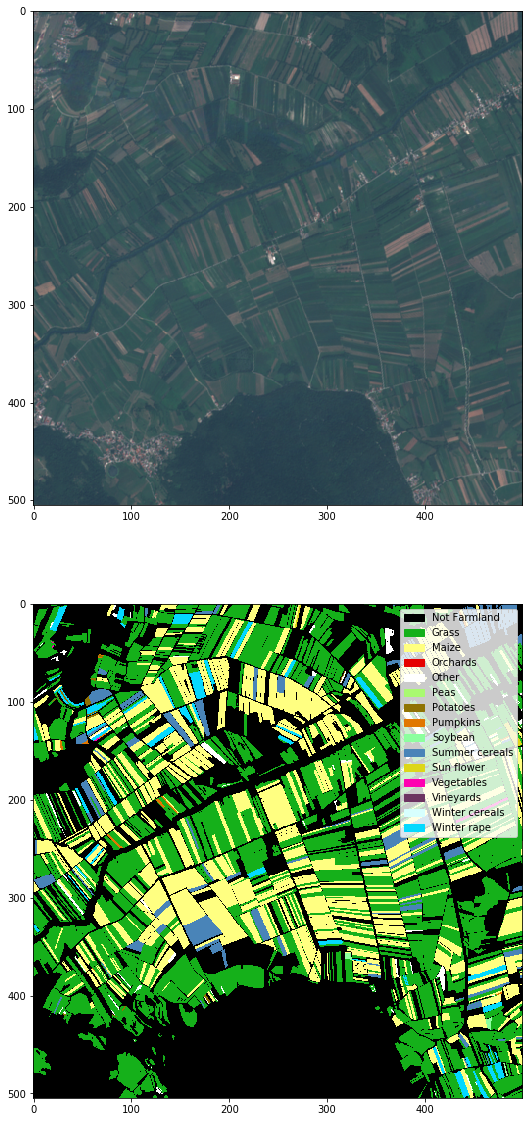

In [52]:
patch_name = next(os.walk(input_path))[1][0]
eopatch = EOPatch.load(f'{save_path}/{patch_name}')
lpis = eopatch.mask_timeless[name_of_feature].squeeze()
img = np.clip(eopatch.data['BANDS'][10][..., [3, 2, 1]] * 3.5, 0, 1)

handles = []
labels = []
for i in range(len(group_colors)):
    patch = mpatches.Patch(color=group_colors[i][1], label=group_colors[i][0])
    labels.append(group_colors[i][0])
    handles.append(patch)

plt.figure(figsize=(10, 20))
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.legend(handles, labels)
plt.imshow(lpis, cmap=cmap, norm=norm)
plt.show()